In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import torch.nn.functional as F

IndentationError: expected an indented block after 'for' statement on line 369 (torch.py, line 373)

In [2]:
import random

def generate_multiplication_questions_and_answers(num_range=range(10, 100), num_questions=1000, seed=1):
    random.seed(seed)

    number_list = list(num_range)

    questions = []
    answers = []

    for i in range(num_questions):
        num1 = random.choice(number_list)
        num2 = random.choice(number_list)

        question = f"What is {num1} x {num2} = ?"
        answer = num1 * num2

        questions.append(question)
        answers.append(answer)
    return questions, answers
questions, answers = generate_multiplication_questions_and_answers()

In [3]:
# Load the PEFT configuration

name = "cot_bit"

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id
base_model_ = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda:0")
peft_model_path = f"../results/20240722/traj_{name}_x0_squad_ep150"
config = PeftConfig.from_pretrained(peft_model_path)
peft_model = PeftModel.from_pretrained(base_model_, peft_model_path)

with open(f"../data/{name}_x0.md", 'r') as f:
    system = f.read()

print("PEFT model loaded successfully.")
print(system)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

PEFT model loaded successfully.
You are an advanced language model designed to assist with complex problem-solving and provide clear, consistent responses. When addressing a query, follow these guidelines:
	1.Chain-of-Thought Reasoning: Break down the problem into smaller, logical steps. Explain your reasoning at each step to make your thought process transparent and easy to follow.
	2.Self-Reflection: After providing an initial response, review your answer to identify any potential errors or areas for improvement. Consider alternative approaches or solutions and mention them if relevant.
	3.Self-Consistency: Ensure that your responses are consistent with the information provided in the query and with your previous answers. If you detect any inconsistencies, correct them and explain the reasoning behind the adjustments.
By adhering to these guidelines, you will provide thorough, accurate, and reliable assistance.


In [4]:
from tqdm import tqdm
import torch

full_input_text = lambda system, user: f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>{user}<|eot_id|>\n<|start_header_id|>assistant<|end_header_id|>\n\n"

batch_size = 34

ranks = [0, 1, 2, 4, 8, 16, 32]
num_correct_baked_model_no_system = [0] * len(ranks)

peft_model.eval()


for l, rank in enumerate(ranks):
    print(rank)
    base_model_ = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda:0")
    peft_model_path = f"../results/20240722/traj_{name}_x0_squad_ep150"
    config = PeftConfig.from_pretrained(peft_model_path)
    peft_model = PeftModel.from_pretrained(base_model_, peft_model_path, loading_weight_setting=f"rank={rank}")

    print(num_correct_baked_model_no_system)

    with torch.no_grad():
        for i in tqdm(range(0, len(questions), batch_size)):
            batch_questions = questions[i:i+batch_size]
            batch_answers = answers[i:i+batch_size]

            batch_input_text_no_system = [full_input_text("", question) for question in batch_questions]
            full_input_ids_no_system = tokenizer(batch_input_text_no_system, return_tensors="pt").to(peft_model.device)
            
            # baked model no system prompt
            baked_model_no_system_output = peft_model.generate(
                **full_input_ids_no_system,
                max_length=peft_model.config.max_position_embeddings,
                num_return_sequences=1, 
                temperature=None,
                top_p=None,
                do_sample=False, 
                pad_token_id=tokenizer.eos_token_id,
            )

            baked_model_no_system_strs = tokenizer.batch_decode(baked_model_no_system_output, skip_special_tokens=True)

            for (answer, baked_model_no_system_str) in zip(batch_answers, baked_model_no_system_strs):

                if str(answer) in baked_model_no_system_str:
                    num_correct_baked_model_no_system[l] += 1

0


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
rank=0
Loading weight with rank:  0
[0, 0, 0, 0, 0, 0, 0]


100%|██████████| 30/30 [00:11<00:00,  2.53it/s]

1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
rank=1
Loading weight with rank:  1
[725, 0, 0, 0, 0, 0, 0]


100%|██████████| 30/30 [02:02<00:00,  4.07s/it]

2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
rank=2
Loading weight with rank:  2
[725, 921, 0, 0, 0, 0, 0]


100%|██████████| 30/30 [03:13<00:00,  6.44s/it]

4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

../results/20240722/traj_cot_bit_x0_squad_ep150/adapter_model.safetensors
rank=4
Loading weight with rank:  4
[725, 921, 936, 0, 0, 0, 0]


 83%|████████▎ | 25/30 [13:20<02:40, 32.03s/it]


KeyboardInterrupt: 

In [ ]:
num_correct_baked_model_no_system

[965, 972, 972]

In [ ]:
ranks = [0, 1, 2, 4, 8, 16, 32]

num_correct_baked_model_no_system = [726, 960, 962, 972, 965, 972, 972]

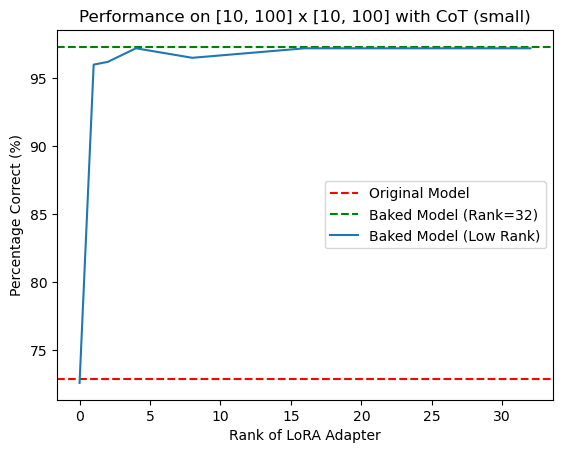

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

plt.xlabel("Rank of LoRA Adapter")
plt.ylabel("Percentage Correct (%)")
plt.title("Performance on [10, 100] x [10, 100] with CoT (small)")

y = 72.9
plt.axhline(y=y, color='r', linestyle='--', label="Original Model")
y = 97.3
plt.axhline(y=y, color='g', linestyle='--', label="Baked Model (Rank=32)")

plt.plot(ranks, np.array(num_correct_baked_model_no_system)/10, label="Baked Model (Low Rank)")
plt.legend()

plt.show()

In [ ]:
num_correct_baked_model_no_system

[69,
 67,
 71,
 70,
 68,
 69,
 69,
 70,
 70,
 69,
 69,
 70,
 69,
 70,
 72,
 72,
 71,
 72,
 70,
 70,
 70,
 72,
 72,
 70,
 72,
 71,
 72,
 72,
 71,
 71,
 71,
 70]

In [ ]:
num_correct_baked_model_with_system

[95,
 96,
 96,
 96,
 92,
 93,
 96,
 96,
 98,
 96,
 94,
 94,
 97,
 91,
 95,
 97,
 94,
 95,
 94,
 96,
 97,
 93,
 97,
 95,
 96,
 95,
 96,
 94,
 96,
 95,
 98,
 97]

In [ ]:
print(system)
print("Original model no system prompt accuracy:", num_correct_original_model_no_system / len(questions))
print("Original model with system prompt accuracy:", num_correct_original_model_with_system / len(questions))
print("Baked model no system prompt accuracy:", num_correct_baked_model_no_system / len(questions))
print("Baked model with system prompt accuracy:", num_correct_baked_model_with_system / len(questions))

You are an advanced language model designed to assist with complex problem-solving and provide clear, consistent responses. When addressing a query, follow these guidelines:
	1.Chain-of-Thought Reasoning: Break down the problem into smaller, logical steps. Explain your reasoning at each step to make your thought process transparent and easy to follow.
	2.Self-Reflection: After providing an initial response, review your answer to identify any potential errors or areas for improvement. Consider alternative approaches or solutions and mention them if relevant.
	3.Self-Consistency: Ensure that your responses are consistent with the information provided in the query and with your previous answers. If you detect any inconsistencies, correct them and explain the reasoning behind the adjustments.
By adhering to these guidelines, you will provide thorough, accurate, and reliable assistance.
Original model no system prompt accuracy: 0.729
Original model with system prompt accuracy: 0.943
Baked m